In [1]:
import obspy
from obspy.core import UTCDateTime, Stats, Trace
from obspy.taup import TauPyModel
from obspy.imaging.spectrogram import spectrogram
from obspy.signal.tf_misfit import plot_tfr
from scipy.signal import stft, istft

import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
from time import time
import pickle

# Download synthetic data from syngine

In [2]:
# earth model
model = 'prem_a_2s'
skip_exists = True

# ranges
source_depths = np.arange(50e3, 701e3, 25e3)
receiver_dists = np.arange(90, 151, 1)
n_focal_mechanisms = 4
n_seis = len(source_depths) * len(receiver_dists) * n_focal_mechanisms
print('# depths:', len(source_depths))
print('# distances:', len(receiver_dists))
print('# focal mechanisms:', n_focal_mechanisms)
print('# seismograms:', n_seis)

# dir
os.system('mkdir -p synthetics')

# random seed for moment tensor
np.random.seed(0)

# constants
sourcelatitude = 0
sourcelongitude = 0
receiverlatitude = 0
origintime="1970-01-01T00:00:00.000000Z"
starttime="1970-01-01T00:00:00.000000Z"
endtime="1970-01-01T01:00:00.000000Z"
components='R'

# timing
i_seis = 0
i_seis_download = 0
t0 = time()

# retrieve from Syngine
for sourcedepthinmeters in source_depths:
    for receiverlongitude in receiver_dists:
        for i_focal in range(n_focal_mechanisms):
            # source
            strike = np.random.uniform(0, 360)
            dip = np.random.uniform(0, 90)
            rake = np.random.uniform(-180, 180)
            sourcedoublecouple = '%d,%d,%d' % (strike, dip, rake)
            
            # name of the trace
            label = 'depth%d_dist%d_focal%d' % (np.round(sourcedepthinmeters / 1e3), 
                                                receiverlongitude, i_focal)

            # prepare http
            http = "http://service.iris.edu/irisws/syngine/1/query?"
            http += "&model=%s" % model
            http += "&sourcelatitude=%f" % sourcelatitude
            http += "&sourcelongitude=%f" % sourcelongitude
            http += "&sourcedepthinmeters=%f" % sourcedepthinmeters
            http += "&sourcedoublecouple=%s" % sourcedoublecouple
            http += "&receiverlatitude=%f" % receiverlatitude
            http += "&receiverlongitude=%f" % receiverlongitude
            http += "&origintime=%s" % origintime
            http += "&starttime=%s" % starttime
            http += "&endtime=%s" % endtime
            http += "&components=%s" % components
            http += "&label=%s" % label
            http += "&format=miniseed"

            # retrieve from Syngine
            fname = 'synthetics/raw/%s.mseed' % label
            i_seis += 1
            if not os.path.exists(fname) or not skip_exists:
                urllib.request.urlretrieve(http, fname)
                # timing
                i_seis_download += 1
                elapsed = round(time() - t0)
                remain = round(elapsed / i_seis_download * (n_seis - i_seis))
                print(f'Done {i_seis} / {n_seis}; elapsed={elapsed}; remain={remain}', end='\r')

# depths: 27
# distances: 61
# focal mechanisms: 4
# seismograms: 6588


# Filter and slice

In [3]:
# %%script echo SKIPPED

# taup
taup_model = TauPyModel(model="prem")

# filter, slice, resample
fmin = 1 / 200
fmax = 1 / 2
t_pre_SKS = 200
t_post_SKS = 300
resample_rate = 10

# file to store processed seismograms
fname = 'SKS@F[%d,%d]S[%d,%d]R%d' % (1 / fmax, 1 / fmin, t_pre_SKS, t_post_SKS, resample_rate)

# timing
t0 = time()
i_seis = 0

# dict of processed synthetics
dict_synth = {}
for sourcedepthinmeters in source_depths:
    for receiverlongitude in receiver_dists:
        # SKS
        arrivals = taup_model.get_travel_times(
            source_depth_in_km=sourcedepthinmeters / 1e3, 
            distance_in_degree=receiverlongitude, 
            phase_list=['SKS',])
        if(len(arrivals) == 0):
            # SKS not found
            i_seis += n_focal_mechanisms
            continue
        tSKS = arrivals[0].time
        for i_focal in range(n_focal_mechanisms): 
            # read
            label = 'depth%d_dist%d_focal%d' % (np.round(sourcedepthinmeters / 1e3), 
                                                receiverlongitude, i_focal)
            st_synth = obspy.read('synthetics/raw/%s.mseed' % label)[0]
        
            # filter
            st_synth.filter('bandpass', freqmin=fmin, freqmax=fmax)

            # slice
            st_synth_SKS = st_synth.slice(UTCDateTime(tSKS - t_pre_SKS), 
                                          UTCDateTime(tSKS + t_post_SKS))

            # resample
            st_synth_SKS = st_synth_SKS.resample(sampling_rate=resample_rate)
            length = len(st_synth_SKS.data) // 100 * 100

            # save
            dict_synth[label] = [st_synth_SKS.data[:length], 
                                 sourcedepthinmeters / source_depths.max(), 
                                 receiverlongitude / receiver_dists.max()]
            
        # timing
        i_seis += n_focal_mechanisms
        elapsed = round(time() - t0)
        remain = round(elapsed / i_seis * (n_seis - i_seis))
        print(f'Done {i_seis} / {n_seis}; elapsed={elapsed}; remain={remain}', end='\r')

# save
with open('synthetics/processed/%s.pkl' % fname, 'wb') as f:
    pickle.dump(dict_synth, f)

# Time series to image

In [4]:
def curve_to_image(curve, fs=10, nperseg=100, noverlap=90, nfft=4000, truncate_nfft=300):
    f, t, Zxx = stft(curve, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, 
                     detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1)
    return f[:truncate_nfft], t, Zxx[:truncate_nfft, :]

def image_to_curve(image, fs=10, nperseg=100, noverlap=90, nfft=4000):
    return istft(image, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, 
                 input_onesided=True, boundary=True, time_axis=-1, freq_axis=-2)

In [5]:
# load processed data
with open('synthetics/processed/SKS@F[2,200]S[200,300]R10.pkl', 'rb') as f:
    dict_synth = pickle.load(f)

In [6]:
# read curve
curve, depth, dist = list(dict_synth.values())[0]

(300, 501)


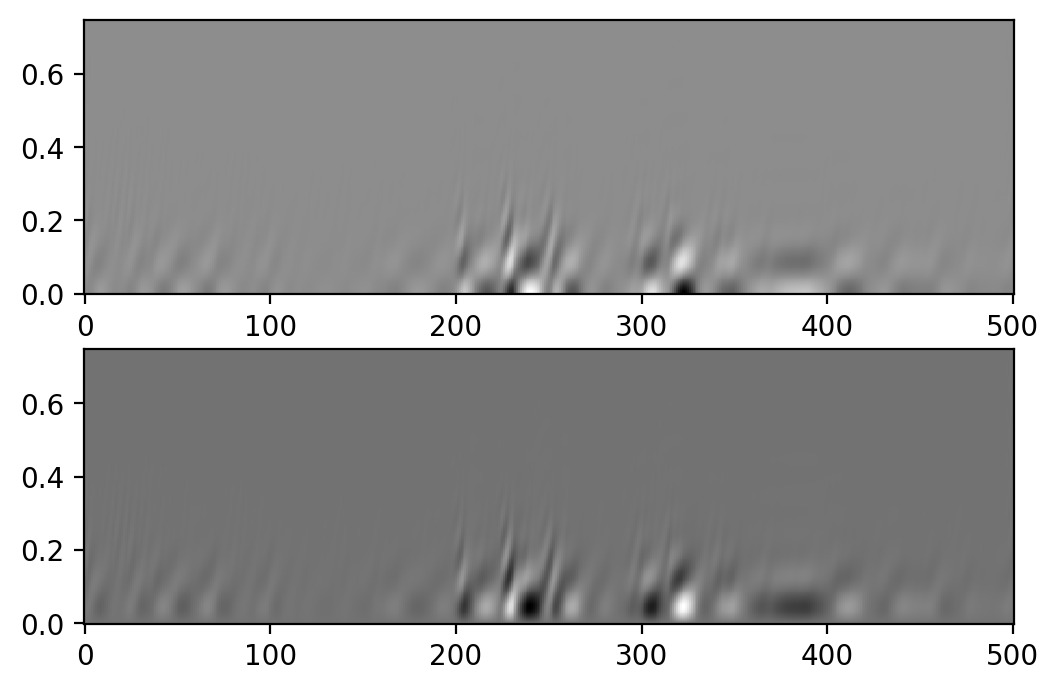

In [7]:
# curve to image
f, t, image = curve_to_image(curve)
print(image.shape)

# plot
fig, ax = plt.subplots(2, 1, dpi=200)
ax[0].pcolormesh(t, f, np.real(image),  shading='auto', cmap='gray')
ax[1].pcolormesh(t, f, np.imag(image),  shading='auto', cmap='gray')
plt.show()

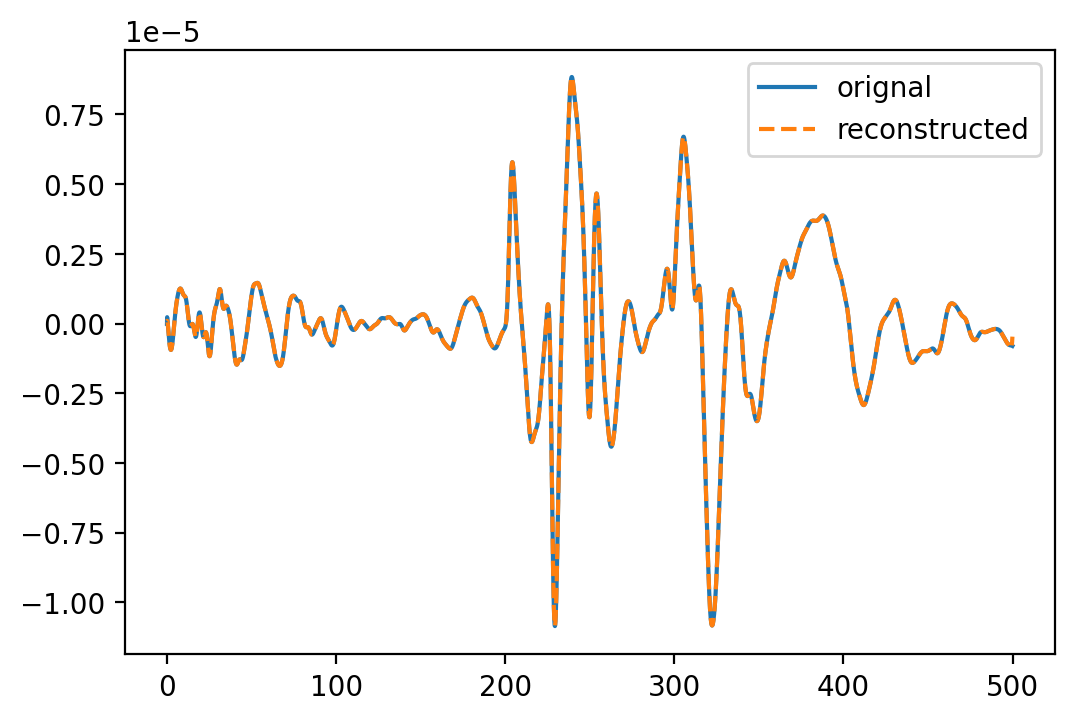

In [11]:
# check if we can reconstruct curve
t, curve_recon = image_to_curve(image)

# plot
plt.figure(dpi=200)
plt.plot(t, curve, label='orignal')
plt.plot(t, curve_recon, label='reconstructed', ls='--')
plt.legend()
plt.show()